In [1]:
%matplotlib notebook

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import os.path as osp
import yaml
import seml
from model.gnn import make_model_by_configuration
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification
from data.gust_dataset import GustDataset
from data.util import data_get_num_attributes, data_get_num_classes, load_data_from_configuration
from torch_geometric.data import Data
from tqdm import tqdm
from collections import defaultdict
from evaluation.lipschitz import logit_space_bounds, local_perturbations
from plot.perturbations import local_perturbations_plot

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    checkpoint_location = 'cuda'
else:
    device = torch.device('cpu')
    checkpoint_location = 'cpu'

In [5]:
collection_name = 'week2_single_model'
collection = seml.database.get_collection(collection_name)
results = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] == 'COMPLETED']

In [6]:
# Reorder results to access them like [model][data][spectral_norm]
runs = defaultdict(lambda: defaultdict(dict))
for result in results:
    config = result['config']
    runs[config['model']['model_type']][config['data']['dataset']][config['model']['use_spectral_norm']] = result

In [7]:
# Load a model
def load_model_and_data(result, collection_name, split_idx=0, initialization=0, load_model_checkpoint=True, checkpoint_location='cpu'):
    data_train, data_val, _ = load_data_from_configuration(result['config']['data'])[0][0]
    input_dim = data_get_num_attributes(data_val[0])
    output_dim = data_get_num_classes(data_val[0])
    backbone = make_model_by_configuration(result['config']['model'], input_dim, output_dim)
    model = SemiSupervisedNodeClassification(backbone, learning_rate=result['config']['training']['learning_rate'])
    if load_model_checkpoint:
        checkpoint_dir = osp.join('/nfs/students/fuchsgru/artifacts', str(collection_name), str(result['id']), f'{split_idx}-{initialization}')
        checkpoint_files = [fname for fname in os.listdir(checkpoint_dir) if fname.endswith('.ckpt')]
        if len(checkpoint_files) > 0:
            print(f'Multiple checkpoints to choose from, use {checkpoint_files[0]}')
        checkpoint_file = osp.join(checkpoint_dir, checkpoint_files[0])
        checkpoint = torch.load(checkpoint_file, map_location=torch.device(checkpoint_location))
        model.load_state_dict(checkpoint['state_dict'])
    
    model.eval()
            
    return model, data_train, data_val

In [10]:
# model, _, data_val = load_model_and_data(runs['gcn']['cora_ml'][True], collection_name, checkpoint_location='cuda')
# random_perturbations = local_perturbations(model, data_val, perturbations=(0.1, 1, 5.0), num_perturbations_per_sample=2)
# local_perturbations_plot(random_perturbations)


In [12]:
def pipeline(result, collection_name, num_perturbations_per_sample=10, 
             output_dir='evaluation/week2/local_lipschitz_plots',
             checkpoint_location='gpu',):
    config = result['config']
    model_type = config['model']['model_type']
    hidden_sizes = '-'.join(map(str, config['model']['hidden_sizes']))
    dataset_name = config['data']['dataset']
    use_spectral_norm = config['model']['use_spectral_norm']
    figure_path = osp.join(output_dir, f'{model_type}-{use_spectral_norm}-{hidden_sizes}-{dataset_name}.pdf')
    if osp.exists(figure_path):
        print(f'Skipping figure {figure_path} because it exists.')
        return
    
    model, data_train, data_val = load_model_and_data(result, collection_name, checkpoint_location=checkpoint_location)
    logits_min, logits_max = logit_space_bounds(model, data_val)
    random_perturbations = local_perturbations(model, data_val, perturbations=np.linspace(0.1, 15.0, 50), num_perturbations_per_sample=num_perturbations_per_sample)
    fig, axs, slope_ys, slope_yupper = local_perturbations_plot(random_perturbations, config=result['config'])
    intervals = [f'[{l:.2f}, {u:.2f}]' for l, u in zip(logits_min.numpy(), logits_max.numpy())]
    #print(f'Intervals of logit space on validation data: {",".join(intervals)}')
    
    
    title = f'{model_type}-{hidden_sizes}, {dataset_name}, Use Spectral Norm: {use_spectral_norm}\nLogit space bounded by [{logits_min.min().item():.2f}, {logits_max.max().item():.2f}]^d'

    axs.set_title(title)
    plt.savefig(figure_path)
    
for result in results:
    pipeline(result, collection_name, output_dir='evaluation_nbs/week2/local_lipschitz_plots', checkpoint_location=checkpoint_location)
    #pipeline(runs['gcn']['cora_ml'][False], collection_name)

Skipping figure evaluation_nbs/week2/local_lipschitz_plots/gat-True-64-64-cora_ml.pdf because it exists.
Skipping figure evaluation_nbs/week2/local_lipschitz_plots/gat-False-64-64-cora_ml.pdf because it exists.
Skipping figure evaluation_nbs/week2/local_lipschitz_plots/gcn-True-64-cora_ml.pdf because it exists.
Skipping figure evaluation_nbs/week2/local_lipschitz_plots/gcn-False-64-cora_ml.pdf because it exists.
Skipping figure evaluation_nbs/week2/local_lipschitz_plots/gin-True-64-cora_ml.pdf because it exists.
Skipping figure evaluation_nbs/week2/local_lipschitz_plots/gin-False-64-cora_ml.pdf because it exists.
Skipping figure evaluation_nbs/week2/local_lipschitz_plots/mlp-True-32-cora_ml.pdf because it exists.
Skipping figure evaluation_nbs/week2/local_lipschitz_plots/mlp-False-32-cora_ml.pdf because it exists.
Skipping figure evaluation_nbs/week2/local_lipschitz_plots/appnp-True-64-64-cora_ml.pdf because it exists.
Skipping figure evaluation_nbs/week2/local_lipschitz_plots/appnp-Fa

In [13]:
# Gather results in reasonable plots, i.e. group by model and dataset
import tempfile
from pdf2image import convert_from_path
from PIL import Image

In [15]:
output_dir='evaluation_nbs/week2/local_lipschitz_plots'
model_plots = defaultdict(list)
for model_type in runs.keys():
    for dataset_type in runs[model_type].keys():
        for spectral_norm in (True, False):
                config = runs[model_type][dataset_type][spectral_norm]['config']
                model_type = config['model']['model_type']
                hidden_sizes = '-'.join(map(str, config['model']['hidden_sizes']))
                dataset_name = config['data']['dataset']
                use_spectral_norm = config['model']['use_spectral_norm']
                figure_path = osp.join(output_dir, f'{model_type}-{use_spectral_norm}-{hidden_sizes}-{dataset_name}.pdf')
                
                with tempfile.TemporaryDirectory() as temp_dir:
                    # convert pdf to multiple image
                    images = convert_from_path(figure_path, output_folder=temp_dir)
                    assert len(images) == 1
                    images[0].save(osp.join(temp_dir, 'tmp.jpg'))
                    image = Image.open(osp.join(temp_dir, 'tmp.jpg'))
                    model_plots[model_type].append(image)
                    

In [22]:
def cov(x, rowvar=False, bias=False, ddof=None, aweights=None):
    """Estimates covariance matrix like numpy.cov
    
    From: https://github.com/pytorch/pytorch/issues/19037#issue-430654869
    """
    # ensure at least 2D
    if x.dim() == 1:
        x = x.view(-1, 1)

    # treat each column as a data point, each row as a variable
    if rowvar and x.shape[0] != 1:
        x = x.t()

    if ddof is None:
        if bias == 0:
            ddof = 1
        else:
            ddof = 0

    w = aweights
    if w is not None:
        if not torch.is_tensor(w):
            w = torch.tensor(w, dtype=torch.float)
        w_sum = torch.sum(w)
        avg = torch.sum(x * (w/w_sum)[:,None], 0)
    else:
        avg = torch.mean(x, 0)

    # Determine the normalization
    if w is None:
        fact = x.shape[0] - ddof
    elif ddof == 0:
        fact = w_sum
    elif aweights is None:
        fact = w_sum - ddof
    else:
        fact = w_sum - ddof * torch.sum(w * w) / w_sum

    xm = x.sub(avg.expand_as(x))

    if w is None:
        X_T = xm.t()
    else:
        X_T = torch.mm(torch.diag(w), xm).t()

    c = torch.mm(X_T, xm)
    c = c / fact

    return c.squeeze()

X = torch.Tensor([[1.0, 2], [3, 4], [5, 6.0]])
torch.unique(torch.arange(3))

tensor([0, 1, 2])

In [16]:
def make_model_plot(images):
    upper_row = images[0::2]
    lower_row = images[1::2]
    width = sum(img.width for img in upper_row)
    height = upper_row[0].height + lower_row[0].height
    
    merged_image = Image.new(images[0].mode, (width, height))
    y = 0
    for row in (upper_row, lower_row):
        x = 0
        for img in row:
            merged_image.paste(img, (x, y))
            x += img.width
        y += img.height
    return merged_image

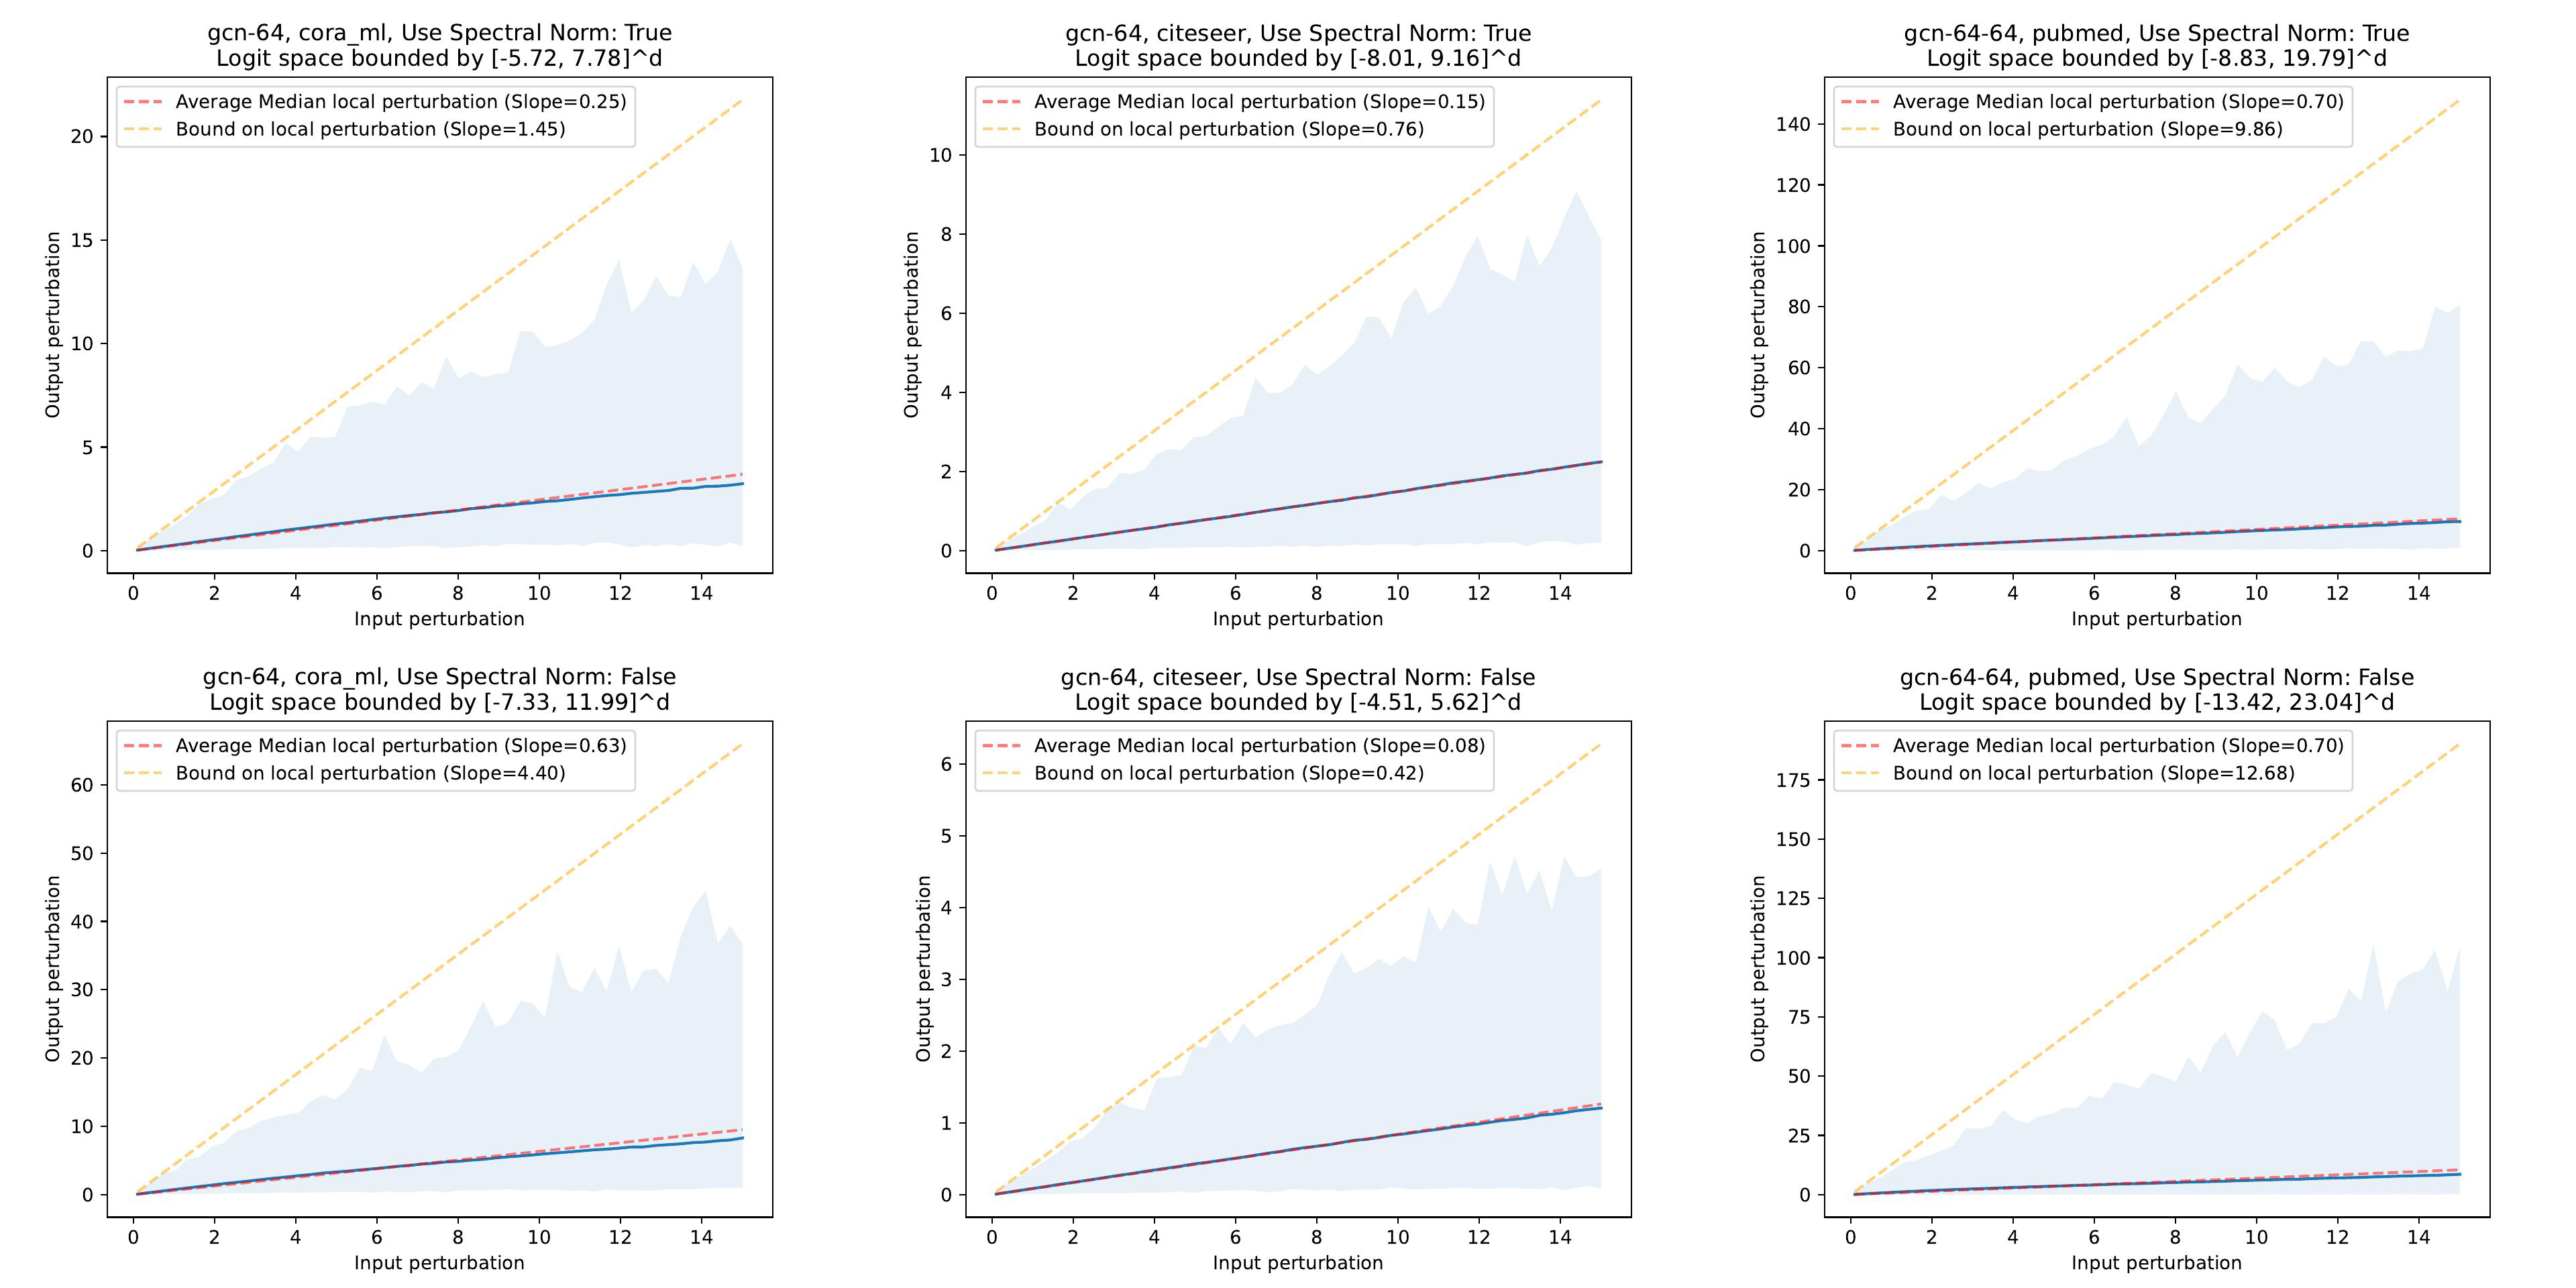

In [17]:
make_model_plot(model_plots['gcn'])

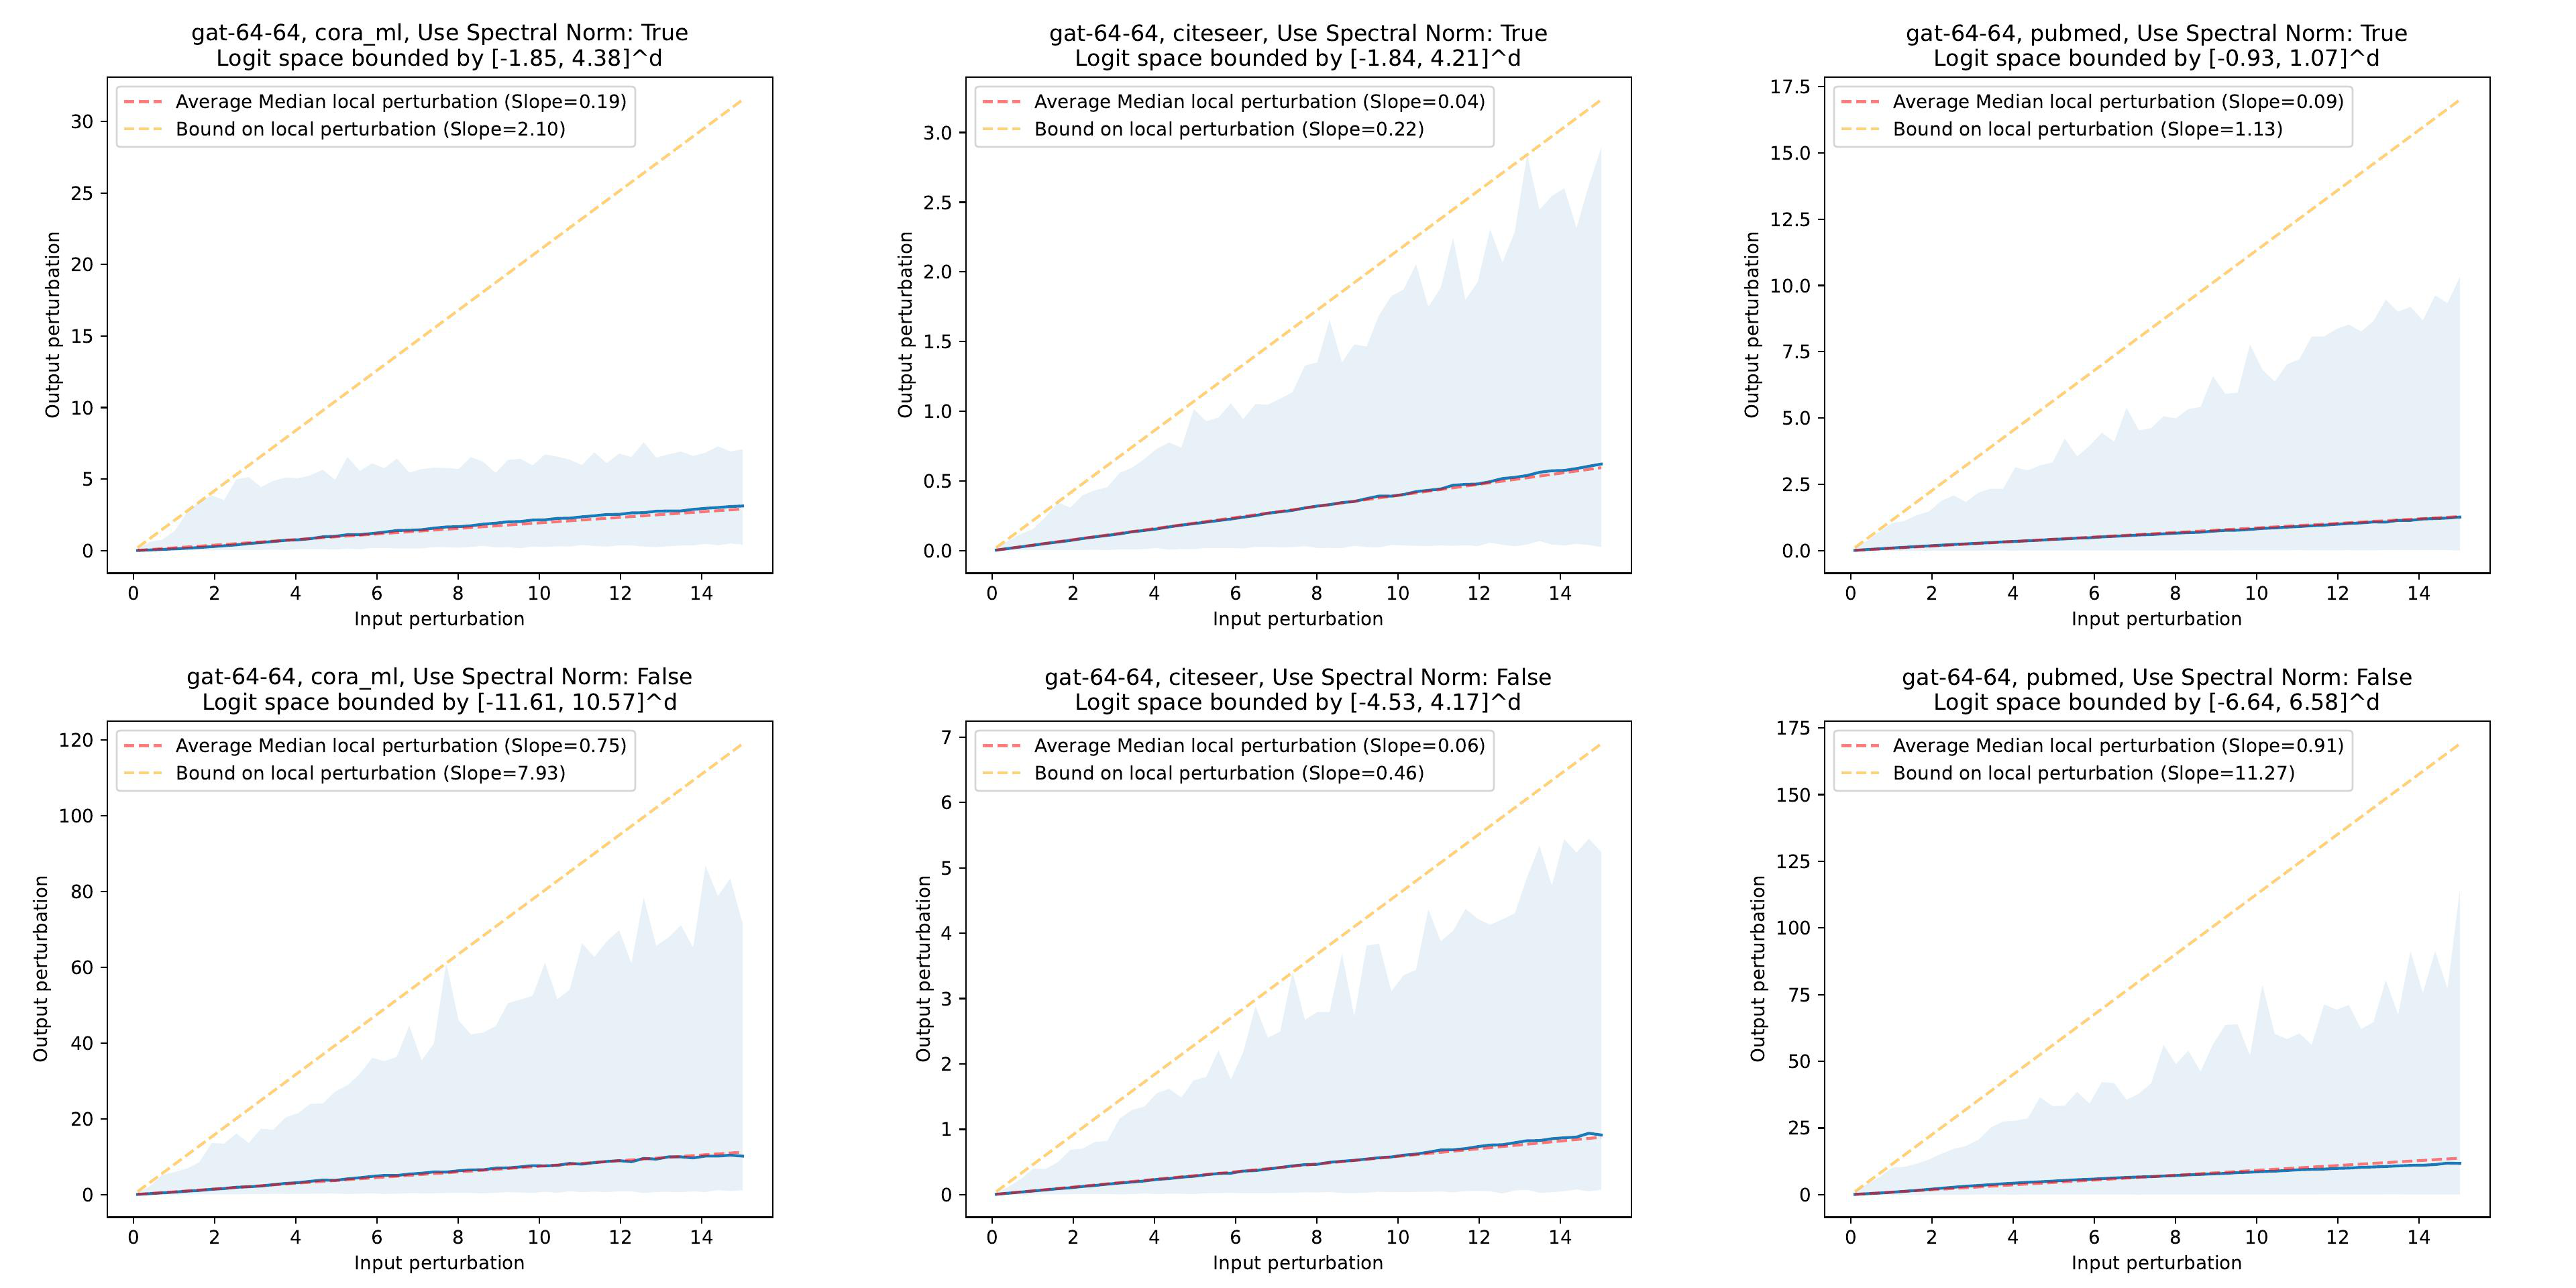

In [46]:
make_model_plot(model_plots['gat'])

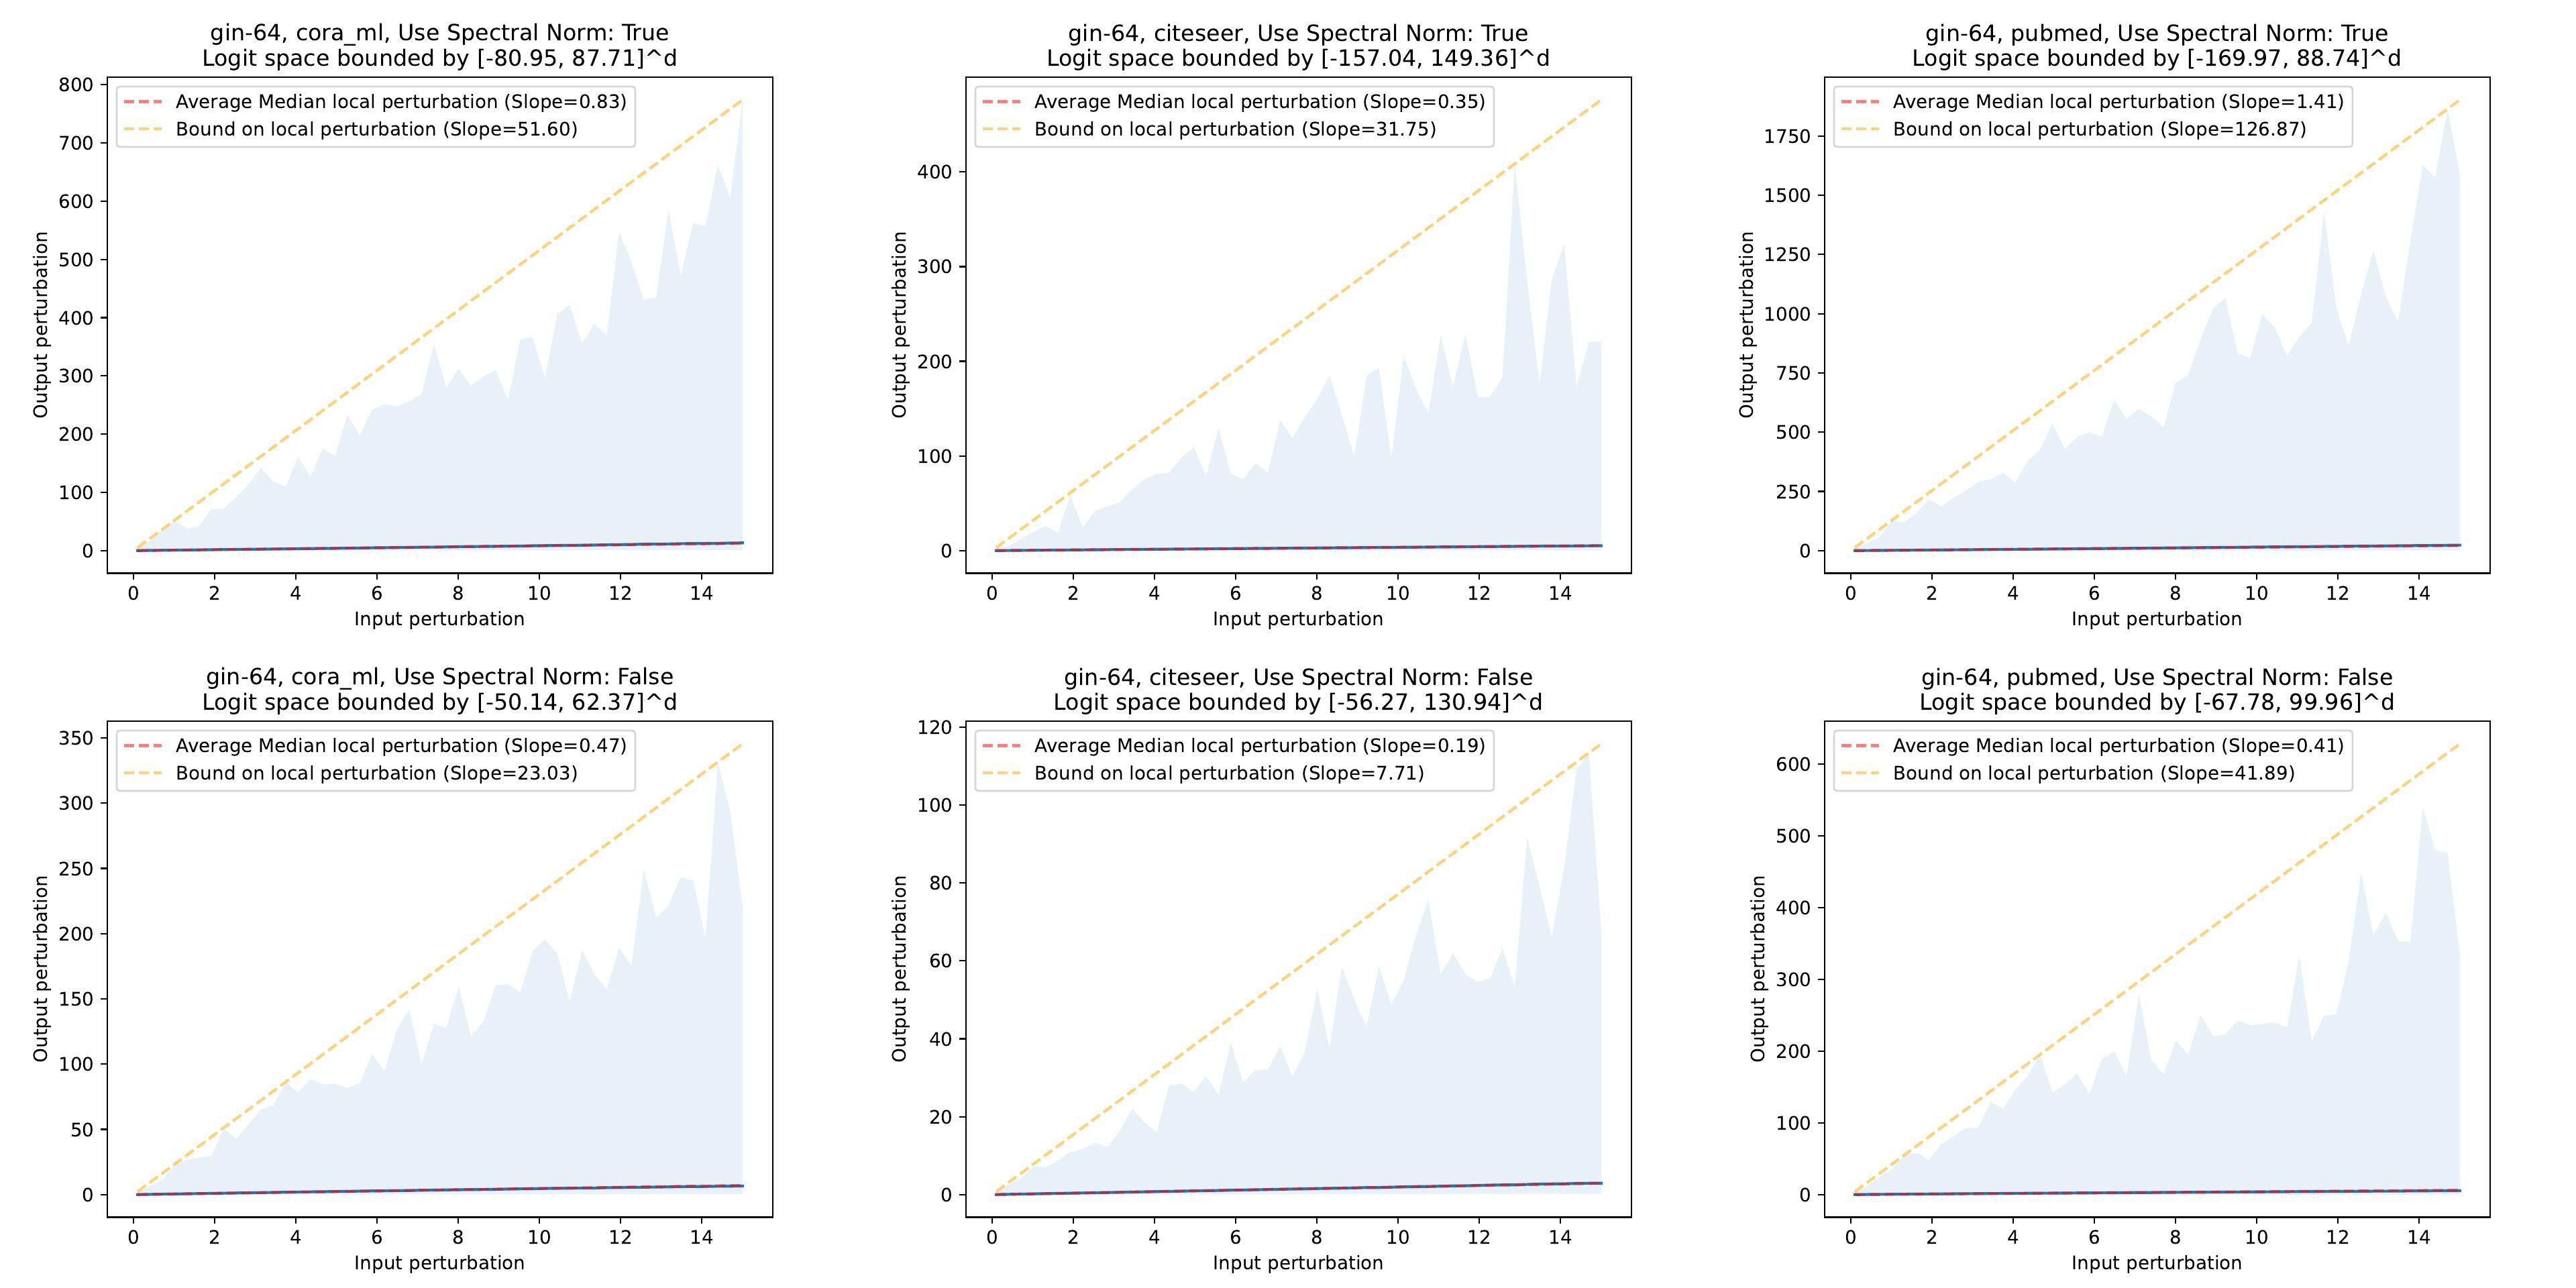

In [47]:
make_model_plot(model_plots['gin'])

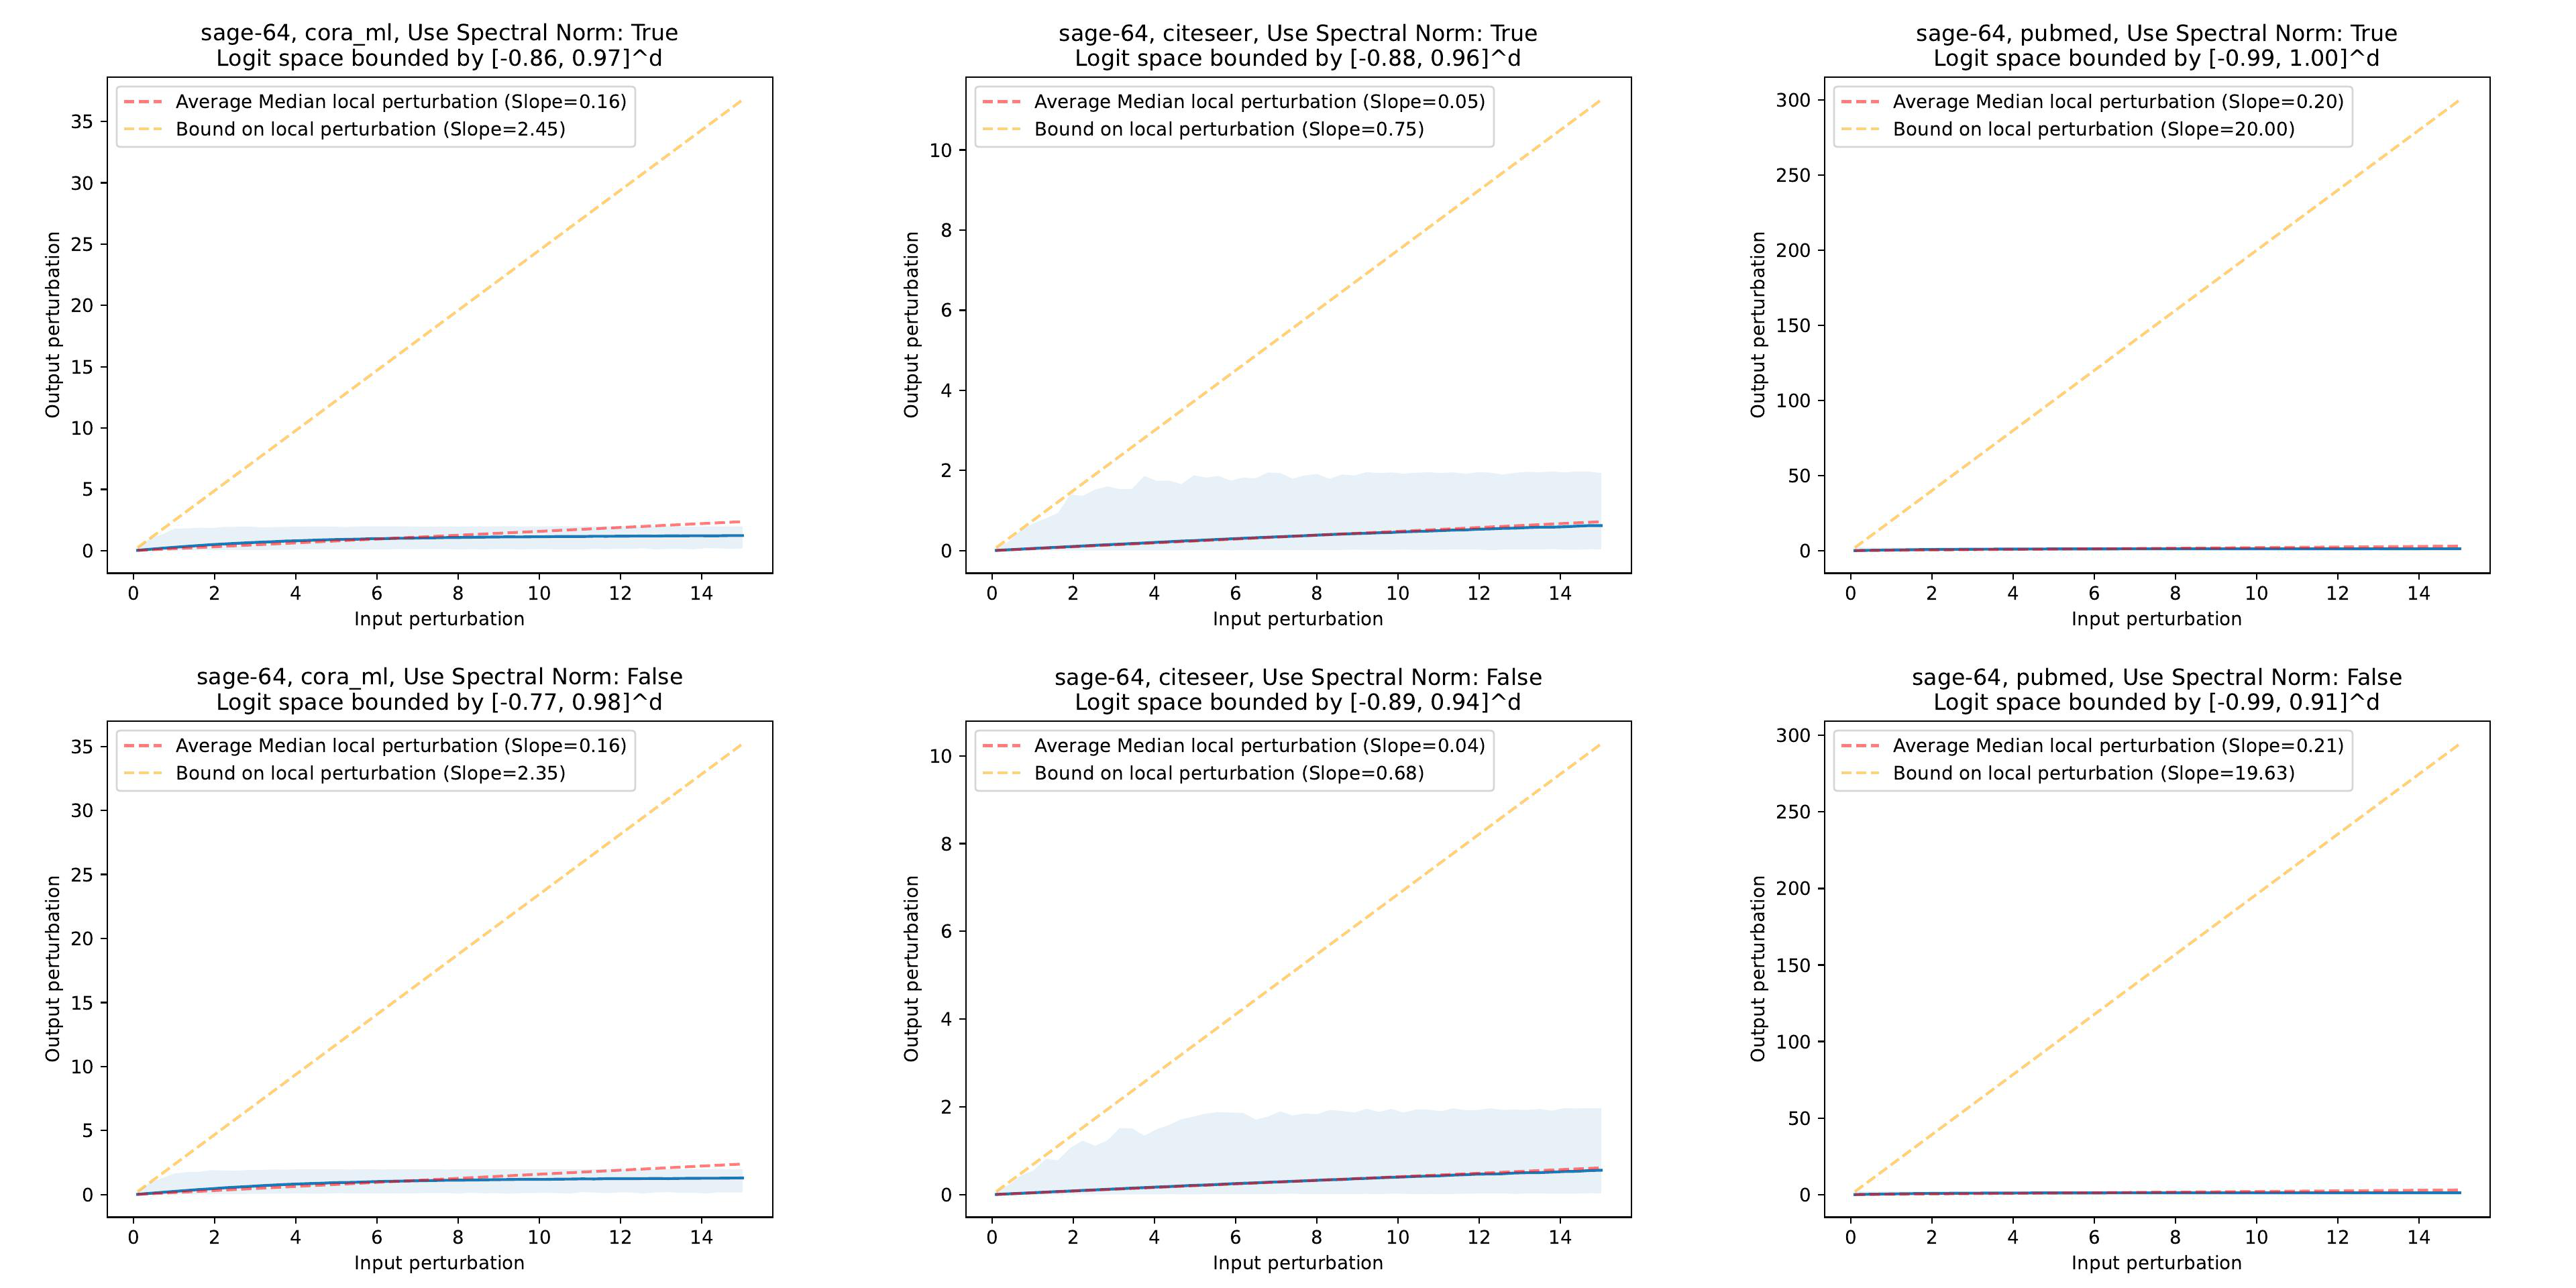

In [48]:
make_model_plot(model_plots['sage'])

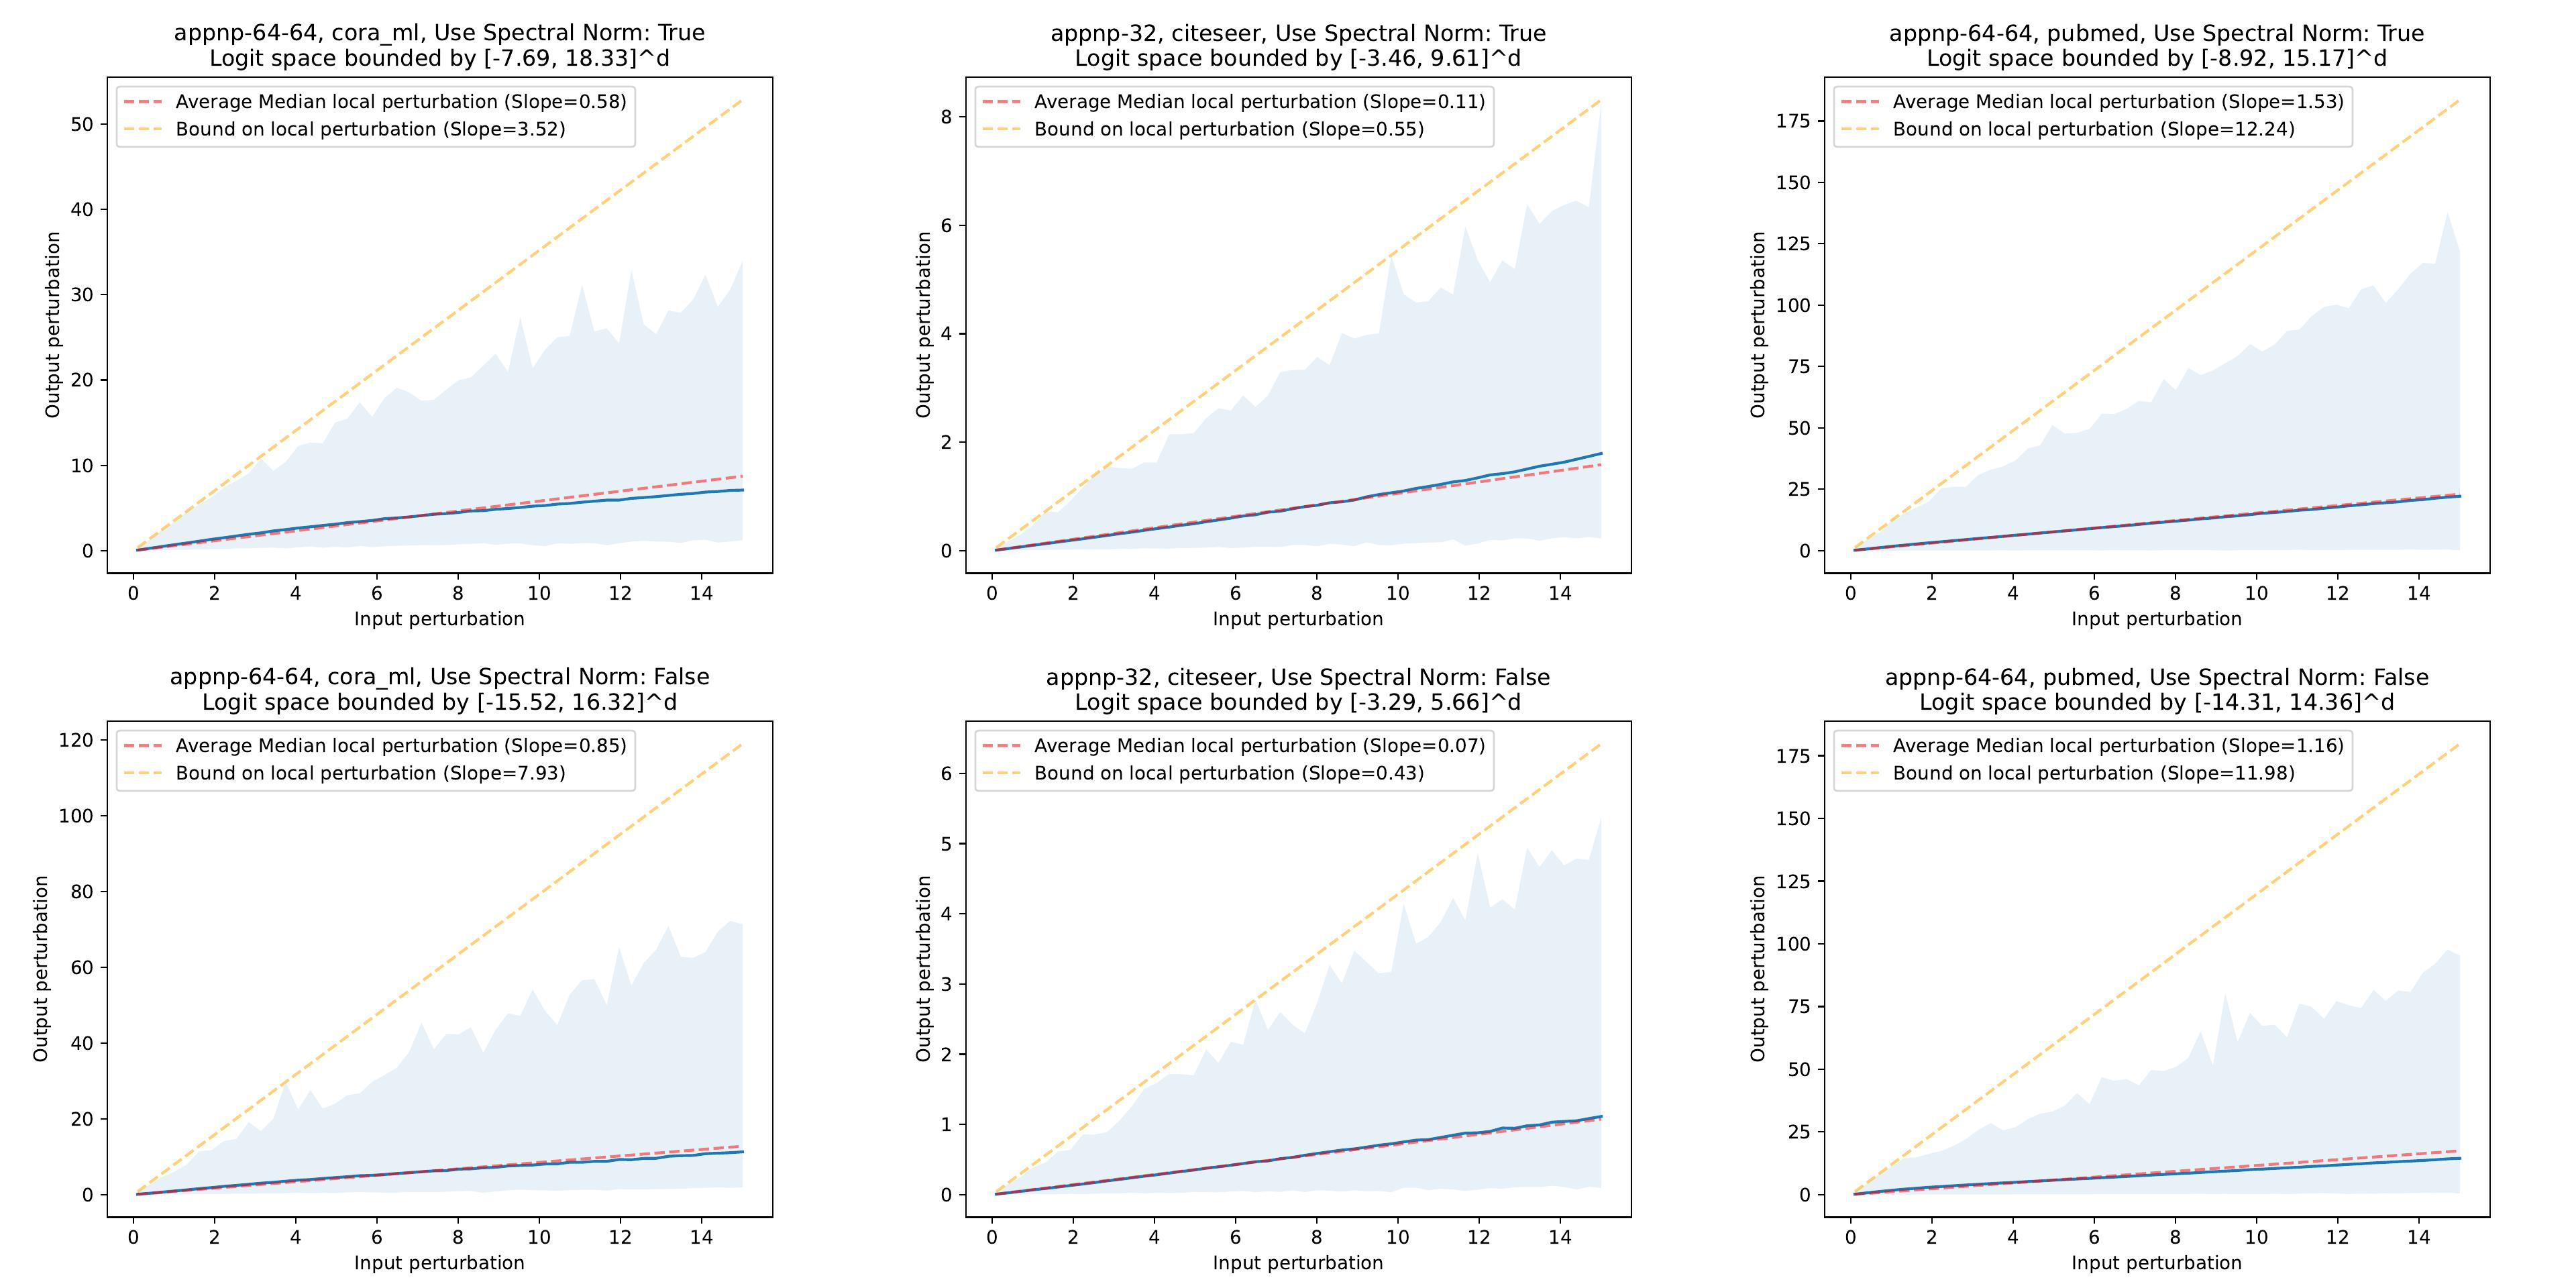

In [49]:
make_model_plot(model_plots['appnp'])

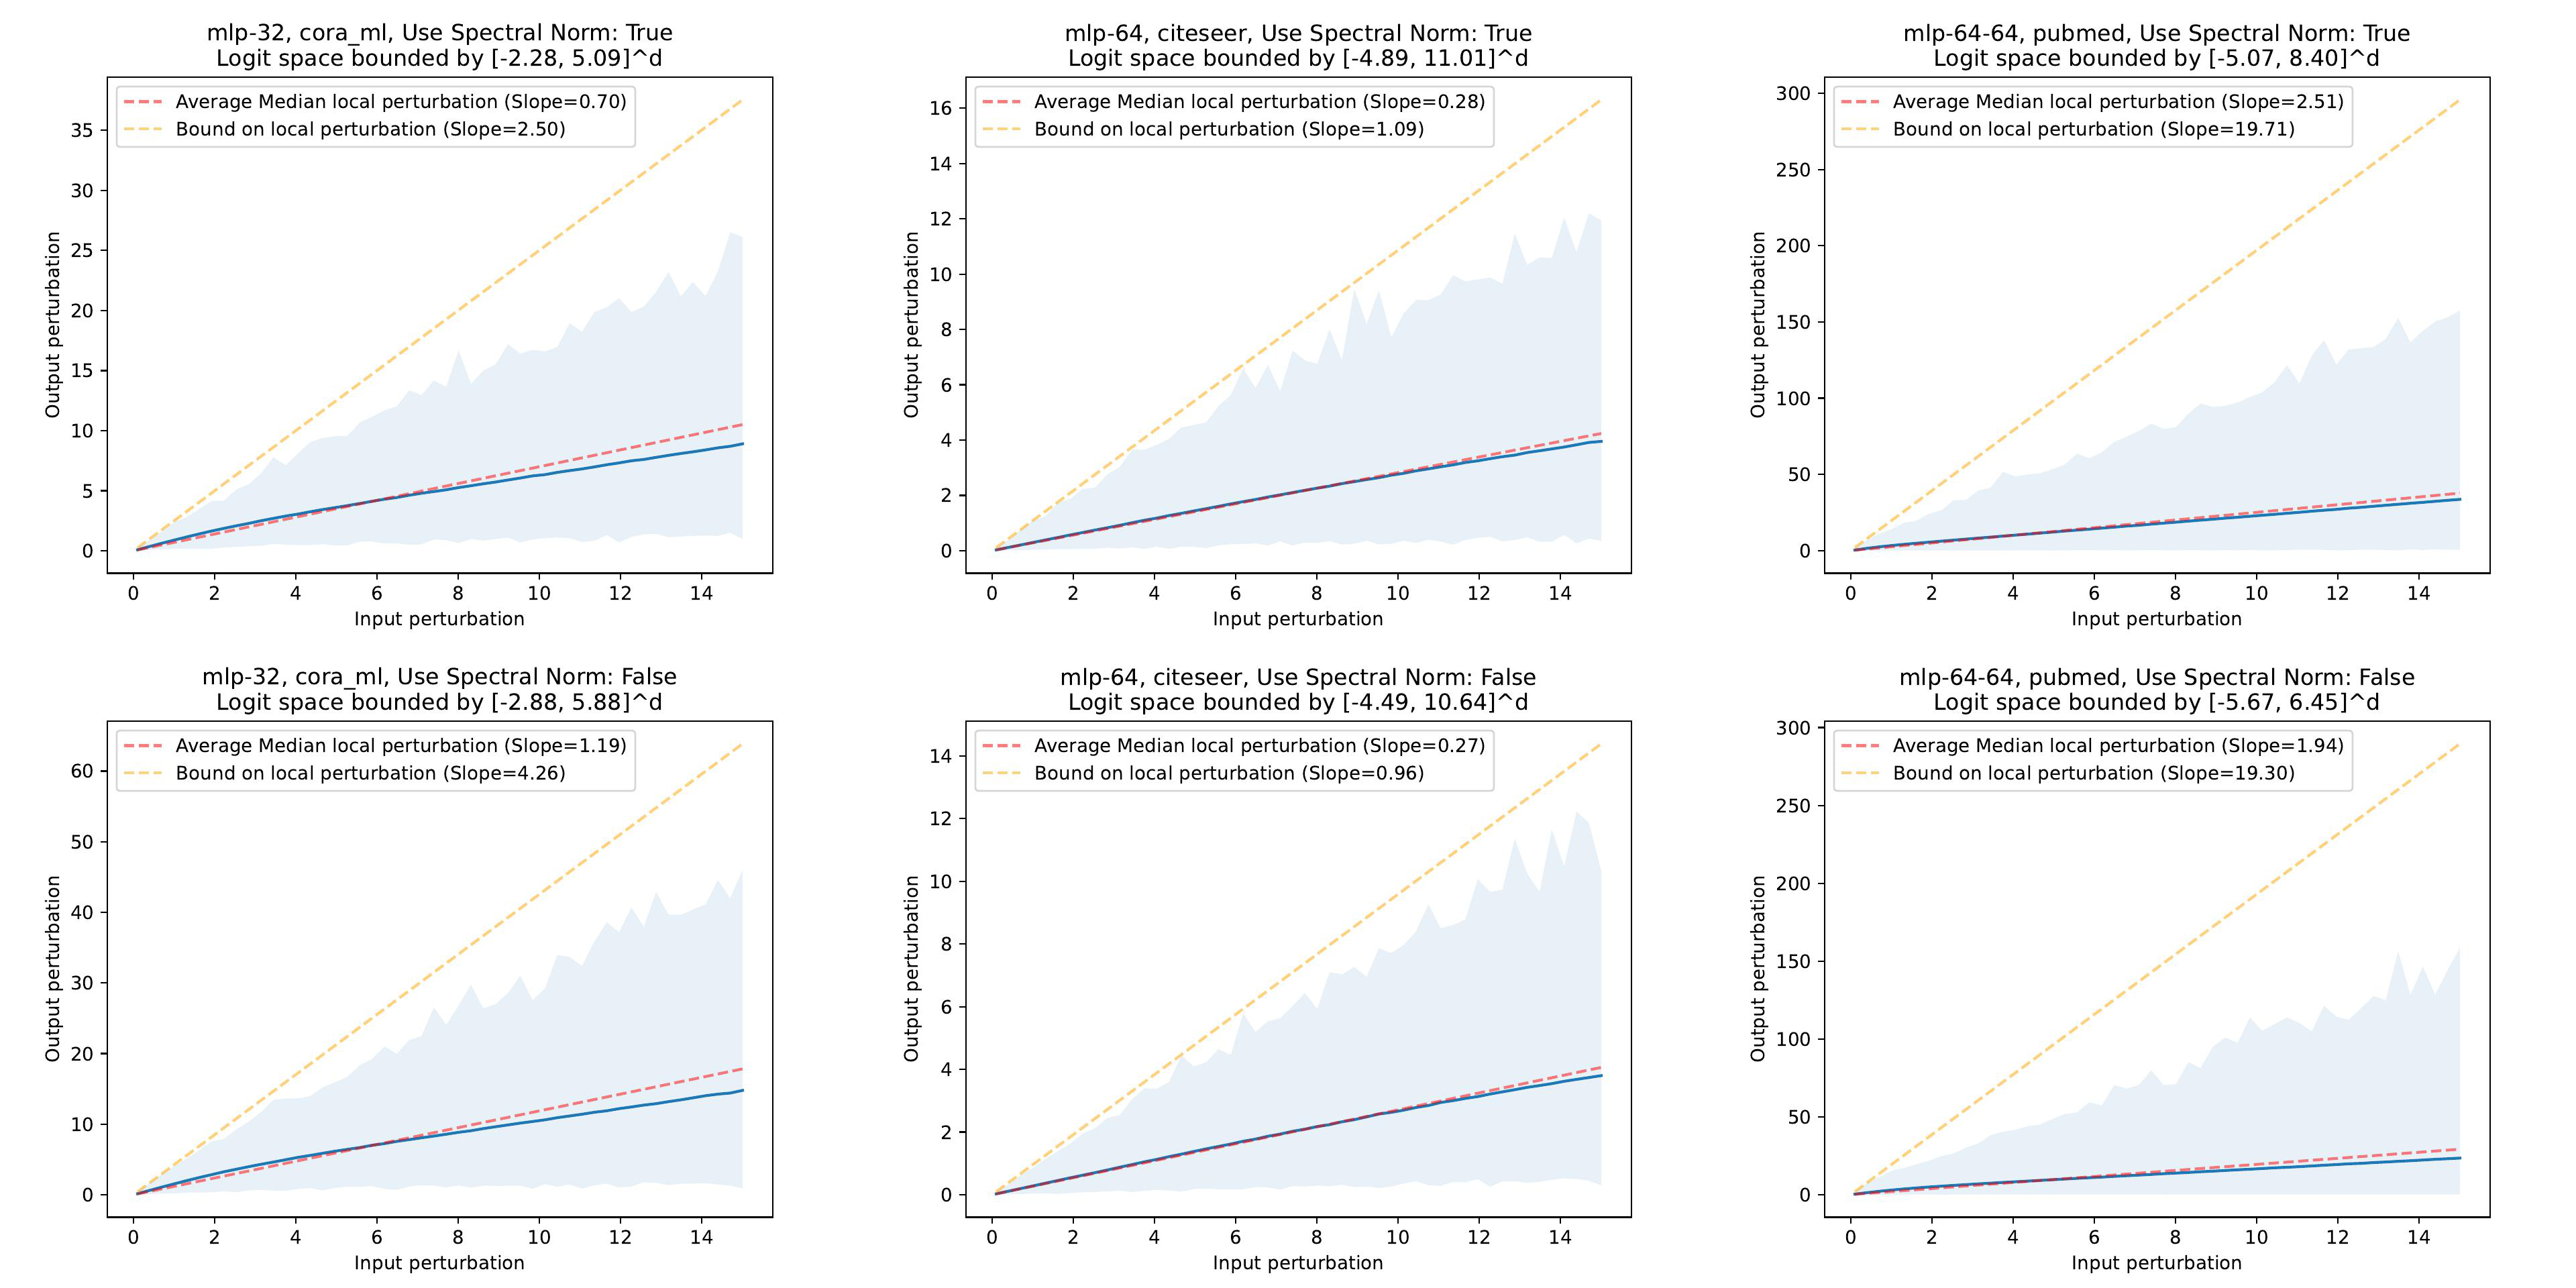

In [50]:
make_model_plot(model_plots['mlp'])